In [1]:
"""
GP emulation
"""
##### Packages ###############
import numpy as np  
import matplotlib.pylab as plt
import time
import pickle
import os
from sklearn.decomposition import PCA
import GPy
import matplotlib.ticker as ticker


In [2]:
############################# PARAMETERS ##############################

dataDir = "./Data/" ## Data folder
modelDir = "./Models/" ## Data folder
plotsDir = "./Plots/" ## Data folder

nRankMax = [4, 8, 16, 32][2]  ## Number of basis vectors in truncated PCA
## Increasing nRankMax will increase emulation precision (asymptotically), but reduce the speed

del_idx = [5, 25, 15]  ## Random holdouts (not used in training, reserved for validation) 


############################# PARAMETERS ##############################

paramIn = dataDir + 'mg.design'
fileIn = dataDir + ['ratios.txt', 'PMG.txt'][0]


In [3]:
loadFile = np.loadtxt(fileIn)
PmPl_all = loadFile[:, 1:].T
kvals = loadFile[:,0]


parameter_array_all = np.loadtxt(paramIn)


############## rescaling ##############


def rescale01(f):
    return (f - np.min(f)) / (np.max(f) - np.min(f))


lhd = np.zeros_like(parameter_array_all)
for i in range(parameter_array_all.shape[1]):
    lhd[:, i] = rescale01(parameter_array_all[:, i])
   

parameter_array_all = lhd

PmPl_all = rescale01(loadFile[:, 1:].T)

############## rescaling ##############


## Removing hold-out test points
parameter_array = np.delete(parameter_array_all, del_idx, axis=0)
PmPl = np.delete(PmPl_all, del_idx, axis=0)

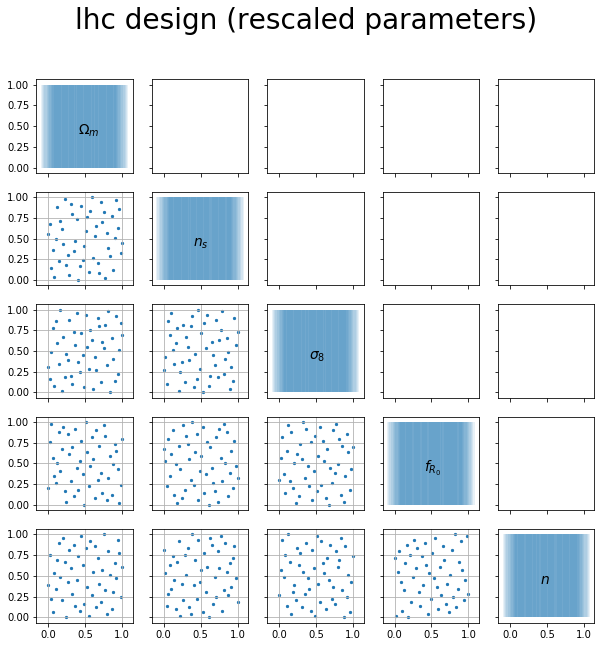

In [4]:
############################# Plot the input parameter distribution ##############################

allLabels = [r'${\Omega}_m$', r'$n_s$', r'${\sigma}_8$', r'$f_{R_0}$', r'$n$']

def rescale01(f):
    return (f - np.min(f)) / (np.max(f) - np.min(f))

lhd = np.zeros_like(parameter_array_all)
for i in range(parameter_array_all.shape[1]):
    lhd[:, i] = rescale01(parameter_array_all[:, i])
    
def plot_params(lhd):
    f, a = plt.subplots(lhd.shape[1], lhd.shape[1], sharex=True, sharey=True, figsize=(10, 10) )
    plt.suptitle('lhc design (rescaled parameters)', fontsize = 28)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    plt.rcParams.update({'font.size': 8})

    for i in range(lhd.shape[1]):
        for j in range(i + 1):
            # print(i, j)
            if (i != j):
                a[i, j].scatter(lhd[:, i], lhd[:, j], s=5)
                a[i, j].grid(True)
            else:
                hist, bin_edges = np.histogram(lhd[:, i], density=True, bins=64)
                a[i, i].text(0.4, 0.4, allLabels[i], size = 'xx-large')

                a[i, i].bar(bin_edges[:-1], hist / hist.max(), width=0.2, alpha = 0.1)


    plt.show()


plot_params(lhd)

In [5]:
########################### PCA ###################################
# set up pca compression
from sklearn.decomposition import PCA


def PCA_compress(x, nComp):
    # x is in shape (nCosmology, nbins)
    pca_model = PCA(n_components=nComp)
    principalComponents = pca_model.fit_transform(x)
    pca_bases = pca_model.components_

    print("original shape:   ", x.shape)
    print("transformed shape:", principalComponents.shape)
    print("bases shape:", pca_bases.shape)

    import pickle
    pickle.dump(pca_model, open(modelDir + 'PCA_model' + str(nRankMax), 'wb'))

    return pca_model, np.array(principalComponents), np.array(pca_bases)


######################## GP FITTING ################################

## Build GP models
# This is evaluated only once for the file name. GP fitting is not required if the file exists.

def GPy_fit0(parameter_array, weights, fname= modelDir + 'GPy_model'):
    kern = GPy.kern.Matern52( np.shape(parameter_array)[1], 0.1)
    m1 = GPy.models.GPRegression(parameter_array, weights, kernel=kern)
#     m1 = GPy.models.GPRegression(parameter_array, weights)

#     m1.Gaussian_noise.variance.constrain_fixed(1e-12)
#     m1.optimize(messages=True)
    m1.save_model(fname + str(nRankMax), compress=True, save_data=True)
    

def GPy_fit(parameter_array, weights, fname= modelDir + 'GPy_model'):
#     kern = GPy.kern.RBF(input_dim= np.shape(parameter_array)[1], lengthscale=1000, variance=1e-10)
    kern = GPy.kern.Matern52(input_dim= np.shape(parameter_array)[1])
    m1 = GPy.models.GPRegression(parameter_array, weights, kernel=kern)
    m1.randomize()
    m1.optimize(optimizer = 'lbfgs', messages=True)
    m1.save_model(fname + str(nRankMax), compress=True, save_data=True)
       


In [6]:
######################## GP PREDICTION FUNCTIONS ###############################

def GPy_predict(para_array):
    m1p = m1.predict(para_array)  # [0] is the mean and [1] the predictive
    W_predArray = m1p[0]
    W_varArray = m1p[1]
    return W_predArray, W_varArray


def Emu(para_array):
    if len(para_array.shape) == 1:
        W_predArray, _ = GPy_predict(np.expand_dims(para_array, axis=0))
        x_decoded = pca_model.inverse_transform(W_predArray)
        return x_decoded[0]

    else:
        W_predArray, _ = GPy_predict(para_array)
        x_decoded = pca_model.inverse_transform(W_predArray)
        return x_decoded.T

In [7]:
pca_model, pca_weights, pca_bases = PCA_compress(PmPl, nComp=nRankMax)
GPy_fit(parameter_array, pca_weights)

original shape:    (47, 20)
transformed shape: (47, 16)
bases shape: (16, 20)


In [8]:
PmPl_all.max(), PmPl_all.min()

(1.0, 0.0)

Time per emulation 0.00098  s
Time per emulation 0.00062  s
Time per emulation 0.00067  s


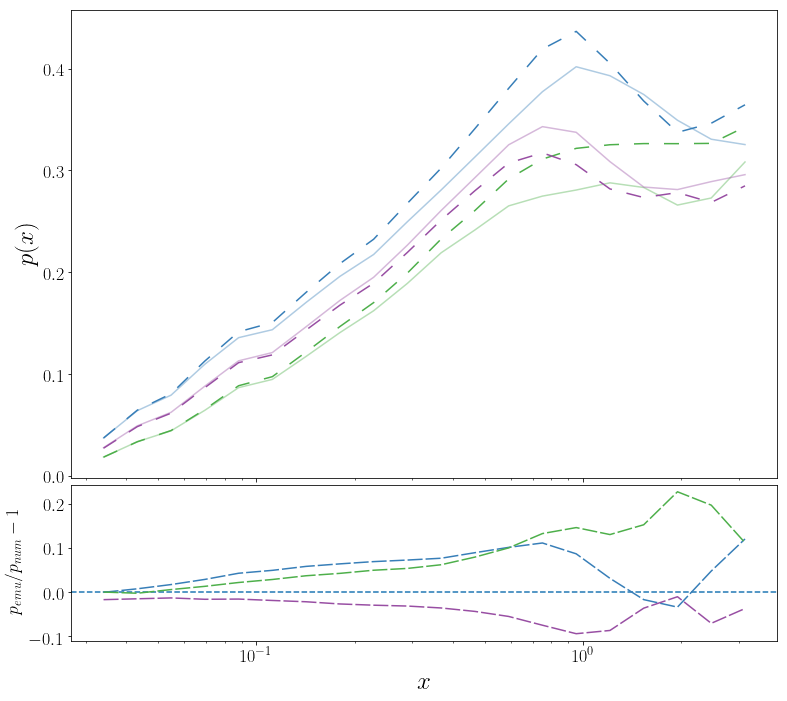

In [9]:
#### GP POSTERIOR DRAWS and PCA RECONSTRUCTIONS ######

# m1 = GPy.models.GPRegression.load_model(modelDir + 'GPy_model_rank' +str(nRankMax)+ '.zip')
# pca_model = pickle.load(open(modelDir + 'PCA_model_rank'+str(nRankMax), 'rb'))

m1 = GPy.models.GPRegression.load_model(modelDir + 'GPy_model'+ str(nRankMax) +'.zip')
pca_model = pickle.load(open(modelDir + 'PCA_model' + str(nRankMax), 'rb'))

plt.rc('text', usetex=True)  # Slower
plt.rc('font', size=18)  # 18 usually

plt.figure(999, figsize=(14, 12))
from matplotlib import gridspec

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
gs.update(hspace=0.02, left=0.2, bottom=0.15)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

ax0.set_ylabel(r'$p(x)$', fontsize=25)
ax1.set_xlabel(r'$x$', fontsize=25)
ax1.set_ylabel(r'$p_{emu}/p_{num} - 1$', fontsize = 18)
# ax1.set_ylim(-5e-2, 5e-2)

ax0.set_xscale('log')
# ax0.set_yscale('log')
ax1.set_xscale('log')

ax1.axhline(y=0, ls='dashed')

color_id = 0
for x_id in del_idx:
    color_id = color_id + 1
    time0 = time.time()
#     x_decoded_new = Emu(parameter_array_all[x_id], PCAmodel='PCA_model', GPmodel='GPy_model')
    x_decoded_new = Emu(parameter_array_all[x_id])

    time1 = time.time()
    print('Time per emulation %0.5f' % (time1 - time0), ' s')

    ax0.plot(kvals, x_decoded_new, alpha=1.0, lw = 1.5, ls='--', label='emu', dashes=(10, 10), color=plt.cm.Set1(color_id))

    x_test = PmPl_all[x_id]
    ax0.plot(kvals, x_test, alpha=0.4, label='real', color=plt.cm.Set1(color_id))

    ax1.plot(kvals, (x_decoded_new / (x_test) ) - 1, ls='--', dashes=(10, 2), color=plt.cm.Set1(color_id))


ax0.set_xticklabels([])
plt.savefig(plotsDir + 'Pemu_rank' +str(nRankMax) + '.png', figsize=(28, 24), bbox_inches="tight")
plt.show()

sample emulated value: [0.02731226 0.04641587 0.05779244 0.07955274 0.09913892 0.10523317
 0.12564474 0.14539891 0.16278095 0.18818761 0.21431438 0.23906537
 0.26618309 0.29056628 0.307532   0.30856898 0.2995903  0.29538169
 0.32117989 0.36715702]
0
Time per emulation 0.0005  s
1
Time per emulation 0.0005  s
2
Time per emulation 0.0004  s
5
Time per emulation 0.0008  s
6
Time per emulation 0.0005  s
7
Time per emulation 0.0004  s
8
Time per emulation 0.0004  s


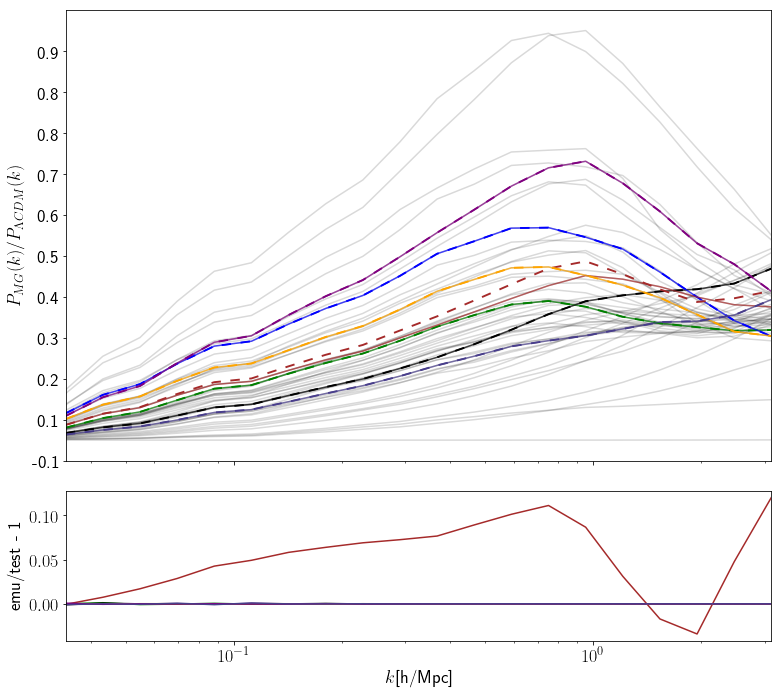

In [10]:
#### GP POSTERIOR DRAWS and PCA RECONSTRUCTIONS ######

## Both models below have to be loaded -- one for GP and one for PCA
m1 = GPy.models.GPRegression.load_model(modelDir + 'GPy_model' + str(nRankMax) + '.zip')
pca_model = pickle.load(open(modelDir + 'PCA_model' + str(nRankMax), 'rb'))


## Calling the Emulator function with 5 arguements [Om, ns, sigma8, fR0, n]

print('sample emulated value:', Emu(np.array([1, 1, 1, 1, 1]) ) )
print(50*'=')

#########################################################

colorList = ['r', 'g', 'k', 'b', 'brown', 'orange', 'purple', 'darkslateblue', 'darkkhaki']

plt.rc('text', usetex=True)  # Slower
plt.rc('font', size=18)  # 18 usually


plt.figure(999, figsize=(14, 12))
from matplotlib import gridspec

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
gs.update(hspace=0.1, left=0.2, bottom=0.15, wspace=0.25)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

ax0.set_ylabel(r'$P_{MG}(k)/P_{{\Lambda}CDM}(k)$')
ax1.set_xlabel(r'$k$[h/Mpc]')
ax1.axhline(y=0, ls='dashed')

# ax0.set_yscale('log')
ax0.set_xscale('log')
ax1.set_xscale('log')

ax1.set_ylabel(r'emu/test - 1')

ax0.plot(kvals, PmPl_all.T, alpha=0.15, color='k')


ax0.set_xlim(kvals[0], kvals[-1])
ax1.set_xlim(kvals[0], kvals[-1])
# ax1.set_ylim(-9e-2, 9e-2)

del_idx = [0, 1, 2, 5, 6, 7, 8]
color_id = 0
for x_id in del_idx:
    print(x_id)
    color_id = color_id + 1
    time0 = time.time()
    x_decodedGPy = Emu(parameter_array_all[x_id])  ## input parameters
    time1 = time.time()
    print('Time per emulation %0.4f' % (time1 - time0), ' s')
    x_test = PmPl_all[x_id]

    ax0.plot(kvals, x_decodedGPy, alpha=1.0, ls='--', lw = 1.9, dashes=(5, 5), label='emu', color=colorList[color_id])
    ax0.plot(kvals, x_test, alpha=0.7, label='test', color=colorList[color_id])
    ax1.plot( kvals, (x_decodedGPy[:]) / (x_test[:])  - 1, color=colorList[color_id])
    
start, end = ax0.get_ylim()
ax0.yaxis.set_ticks((np.arange(start, end, 0.1)))
ax0.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))


ax0.set_xticklabels([])
plt.savefig(plotsDir + 'MGemu_rank' +str(nRankMax) + '.png', figsize=(28, 24), bbox_inches="tight")
plt.show()



In [11]:
######### TEMPLATE FOR MCMC LIKELIHOOD FUNCTION #######################
# For emcee

def lnlike(theta, x, y, yerr):
    p1, p2, p3, p4 = theta
    new_params = np.array([p1, p2, p3, p4])    

    model = Emu(new_params)
    return -0.5 * (np.sum(((y - model) / yerr) ** 2.))


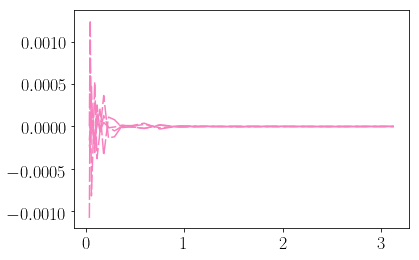

In [12]:
# pca_recon1 = np.matmul(pca_weights, pca_bases)
# pca_recon = pca_model.inverse_transform(pca_weights)
# W_predArray, _ = GPy_predict(np.expand_dims(para_array, axis=0))

test_idx = [0, 1, 2, 3]
for x_id in test_idx:
#     x_pca_recon = np.matmul(pca_weights, pca_bases)
    para_array = parameter_array_all[x_id]
    W_predArray, _ = GPy_predict(np.expand_dims(para_array, axis=0))
    
#     x_emu_recon = pca_model.inverse_transform(W_predArray)
    x_pca_recon = pca_model.inverse_transform(pca_weights)

    x_test = PmPl_all[x_id]
    
#     plt.plot(kvals, (x_emu_recon[0]) / (x_test) - 1, ls=':', color=plt.cm.Set1(color_id))
    plt.plot(kvals, (x_pca_recon[x_id]) / (x_test) - 1, ls='--', dashes=(10, 2), color=plt.cm.Set1(color_id))

#     plt.plot(kvals, (x_test) , ls='-', color=plt.cm.Set1(color_id))
#     plt.plot(kvals, x_pca_recon[x_id], ls='--', dashes=(10, 2), color=plt.cm.Set1(color_id))
#     plt.scatter((W_predArray[0]), pca_weights[x_id])

plt.show()


A-B 2.220446049250313e-16
A-true 0.00011168336021638581
B-true 0.00011168336021644132
emuA-true 7.744346956780264
emuB-true 0.0004738395570522691


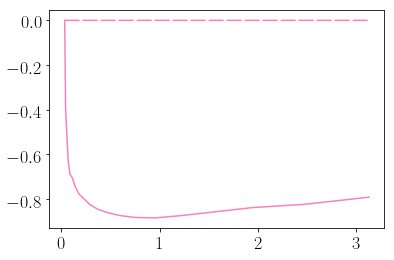

In [13]:
pca_recon = np.matmul(pca_weights, pca_bases)
x_pca_recon == pca_recon[x_id]
x_pca_recon_ind = pca_model.inverse_transform(pca_weights[x_id])

# x_emu_ind = GPy_predict(np.expand_dims(para_array, axis=0)
# x_emu = GPy_predict(np.expand_dims(para_array, axis=0)

x_emu_ind = Emu(np.expand_dims(parameter_array_all[x_id], axis=0) )
x_emu = Emu(parameter_array_all)

print('A-B', np.abs(x_pca_recon[x_id] - x_pca_recon_ind).max())
print('A-true', np.abs(x_pca_recon[x_id] - PmPl_all[x_id]).max())
print('B-true', np.abs(PmPl_all[x_id] - x_pca_recon_ind).max())
print('emuA-true', np.abs(PmPl_all[x_id]/x_emu_ind - 1).max())
print('emuB-true', np.abs(PmPl_all[x_id]/x_emu[:,x_id]- 1).max())

plt.plot(kvals, (x_emu[:,x_id]) / (PmPl_all[x_id] ) - 1, ls='--', dashes=(10, 2), color=plt.cm.Set1(color_id))
plt.plot(kvals, (x_emu_ind[0] / PmPl_all[x_id] ) - 1, ls='-', color=plt.cm.Set1(color_id))

In [14]:
del_idx

[0, 1, 2, 5, 6, 7, 8]